In [1]:
"""
## CEVAE on IHDP - python3, PyTorch

# by Rik Helwegen
# MSc AI - thesis, University of Amsterdam
# 2019

# original implementation (python2, TF, Edward):
https://github.com/AMLab-Amsterdam/CEVAE/blob/master/cevae_ihdp.py

"""
import numpy as np
import matplotlib.pyplot as plt
# from collections import defaultdict

from torchvision import models

import torch
from torch.distributions import normal
from torch import optim

# import pandas as pd
# import seaborn as sns
from progressbar import ETA, Bar, Percentage, ProgressBar
import time
from scipy.stats import sem

#引数を受け取る処理を簡単に実行できる標準化ライブラリをimport
from argparse import ArgumentParser

#自作モジュールのimport
from initialisation import init_qz
from datasets import IHDP
from evaluation_fortorch import Evaluator, get_y0_y1, get_y0_y1_3
from networks_fortorch_new import p_x_z, p_t_z, p_y_zt, q_t_x, q_y_xt, q_z_tyx

In [2]:
# set random seeds:
# torch.manual_seed(7)
# np.random.seed(7)

parser = ArgumentParser()

# Set Hyperparameters
parser.add_argument('-reps', type=int, default=1)
parser.add_argument('-z_dim', type=int, default=20)
parser.add_argument('-h_dim', type=int, default=200)
parser.add_argument('-epochs', type=int, default=100)
parser.add_argument('-batch', type=int, default=100)
parser.add_argument('-lr', type=float, default=0.0001)
parser.add_argument('-decay', type=float, default=1e-4)
parser.add_argument('-print_every', type=int, default=10)
parser.add_argument('-earl', type=int, default=1)

args = parser.parse_args(args=[])

# データセット
dataset = IHDP(replications=args.reps)

d = args.z_dim
nh = 3
h = args.h_dim

In [3]:
# 評価指標保存用
scores = np.zeros((args.reps, 3))
scores_test = np.zeros((args.reps, 3))
ite_train_list = np.zeros([args.reps, args.epochs])
ate_train_list = np.zeros([args.reps, args.epochs])
pehe_train_list = np.zeros([args.reps, args.epochs])
rmse_f_list = np.zeros([args.reps, args.epochs])
rmse_cf_list = np.zeros([args.reps, args.epochs])
ite_test_list = np.zeros([args.reps, args.epochs])
ate_test_list = np.zeros([args.reps, args.epochs])
pehe_test_list = np.zeros([args.reps, args.epochs])
loss = np.zeros([8, args.reps, args.epochs*40])
logpvalid_list = np.zeros([args.reps, args.epochs])

# Loop for replications
for i, (train, valid, test, contfeats, binfeats) in enumerate(dataset.get_train_valid_test()):
    print('\nReplication %i/%i' % (i + 1, args.reps))
    
    torch.manual_seed(0)
    
    # read out data
    (xtr, ttr, ytr), (y_cftr, mu0tr, mu1tr) = train
    (xva, tva, yva), (y_cfva, mu0va, mu1va) = valid
    (xte, tte, yte), (y_cfte, mu0te, mu1te) = test
    
    perm = binfeats + contfeats
    xtr, xva, xte = xtr[:, perm], xva[:, perm], xte[:, perm]
    xalltr, talltr, yalltr = np.concatenate([xtr, xva], axis=0), np.concatenate([ttr, tva], axis=0), np.concatenate([ytr, yva], axis=0)

    # set evaluator objects
    evaluator_train = Evaluator(yalltr, talltr, y_cf=np.concatenate([y_cftr, y_cfva], axis=0),
                                mu0=np.concatenate([mu0tr, mu0va], axis=0), mu1=np.concatenate([mu1tr, mu1va], axis=0))
    evaluator_test = Evaluator(yte, tte, y_cf=y_cfte, mu0=mu0te, mu1=mu1te)

    # zero mean, unit variance for y during training, use ym & ys to correct when using testset
    ym, ys = np.mean(ytr), np.std(ytr)
    ytr, yva = (ytr - ym) / ys, (yva - ym) / ys
    best_logpvalid = - np.inf
    
    # init networks (overwritten per replication)
    # xの次元設定
    x_dim = len(binfeats) + len(contfeats)
    p_x_z_dist = p_x_z(nh, d, h, binfeats, contfeats)
    p_t_z_dist = p_t_z(d, h)
    p_y_zt_dist = p_y_zt(d, nh, h)
    q_t_x_dist = q_t_x(h, x_dim)
    q_y_xt_dist = q_y_xt(nh, h, x_dim)
    q_z_tyx_dist = q_z_tyx(nh, h, d, x_dim)
    p_z_dist = normal.Normal(torch.zeros(args.z_dim), torch.ones(args.z_dim))

    # Create optimizer
    params = list(p_x_z_dist.parameters()) + \
             list(p_t_z_dist.parameters()) + \
             list(p_y_zt_dist.parameters()) + \
             list(q_t_x_dist.parameters()) + \
             list(q_y_xt_dist.parameters()) + \
             list(q_z_tyx_dist.parameters())

    # Adam is used, like original implementation, in paper Adamax is suggested
    optimizer = optim.Adam(params, lr=args.lr, weight_decay=args.decay)

    # init q_z inference ←これ何？
    q_z_tyx_dist = init_qz(q_z_tyx_dist, p_z_dist, ytr, ttr, xtr)

    # set batch size
    M = args.batch

    n_epoch, n_iter_per_epoch, idx = args.epochs, 10 * int(xtr.shape[0] / M), list(range(xtr.shape[0]))

    # loss = defaultdict(list)
    patience = 0
    for epoch in range(n_epoch):
        # q_z_tyx_dist = init_qz(q_z_tyx_dist, p_z_dist, ytr, ttr, xtr)
        avg_loss = 0.
        loss_sum = 0.
        t0 = time.time()
        widgets = ["epoch #%d|" % epoch, Percentage(), Bar(), ETA()]
        pbar = ProgressBar(n_iter_per_epoch, widgets=widgets)
        pbar.start()
        # shuffle index
        np.random.shuffle(idx)
        # take random batch for training
        for j in range(n_iter_per_epoch):
            pbar.update(j)
            # select random batch
            batch = np.random.choice(idx, M)
            x_train, y_train, t_train = torch.FloatTensor(xalltr[batch]), torch.FloatTensor(yalltr[batch]), \
                                        torch.FloatTensor(talltr[batch])
            x_val = torch.FloatTensor(xva)
            y_val = torch.FloatTensor(yva)
            t_val = torch.FloatTensor(tva)
            
            # inferred distribution over z
            xy = torch.cat((x_train, y_train), 1)
            z_infer = q_z_tyx_dist(x_train, t_train, y_train)
            z_infer_sample = z_infer.sample()
            
            # RECONSTRUCTION LOSS
            # p(x|z)
            x_bin, x_con = p_x_z_dist(z_infer_sample)
            l1 = torch.sum(x_bin.log_prob(x_train[:, :len(binfeats)]),axis=1)
            l2 = torch.sum(x_con.log_prob(x_train[:, -len(contfeats):]),axis=1)
            # p(t|z)
            t = p_t_z_dist(z_infer_sample)
            t_sample = t.sample()
            # l3 = torch.sum(t.log_prob(t_train),axis=1)
            l3 = torch.sum(t.log_prob(t_sample),axis=1)
            # p(y|t,z)
            # for training use t_train, in out-of-sample prediction this becomes t_infer
            # y = p_y_zt_dist(z_infer_sample, t_train)
            y = p_y_zt_dist(z_infer_sample, t_sample)
            l4 = torch.sum(y.log_prob(y_train),axis=1)
            
            # REGULARIZATION LOSS
            # p(z) - q(z|x,t,y)
            # approximate KL
            l5 = torch.sum(p_z_dist.log_prob(z_infer_sample) - z_infer.log_prob(z_infer_sample),axis=1)

            # AUXILIARY LOSS
            # q(t|x)
            t_infer = q_t_x_dist(x_train)
            l6 = torch.sum(t_infer.log_prob(t_train),axis=1)
            # q(y|x,t)
            y_infer = q_y_xt_dist(x_train, t_train)
            l7 = torch.sum(y_infer.log_prob(y_train),axis=1)

            # Total objective
            # inner sum to calculate loss per item, torch.mean over batch
            loss_mean = torch.mean(l1 + l2 + l3 + l4 + l5 + l6 + l7)
            objective = -loss_mean

            optimizer.zero_grad()
            # Calculate gradients
            objective.backward()
            # Update step
            optimizer.step()
            #print('Epoch %i' % epoch)
            
            loss[0][i][epoch*n_iter_per_epoch+j] = l1.mean().cpu().detach().float() # Reconstr_x_bin
            loss[1][i][epoch*n_iter_per_epoch+j] = l2.mean().cpu().detach().float() # Reconstr_x_con
            loss[2][i][epoch*n_iter_per_epoch+j] = l3.mean().cpu().detach().float() # Reconstr_t
            loss[3][i][epoch*n_iter_per_epoch+j] = l4.mean().cpu().detach().float() # Reconstr_y
            loss[4][i][epoch*n_iter_per_epoch+j] = l5.mean().cpu().detach().float() # Regularization
            loss[5][i][epoch*n_iter_per_epoch+j] = l6.mean().cpu().detach().float() # Auxiliary_t
            loss[6][i][epoch*n_iter_per_epoch+j] = l7.mean().cpu().detach().float() # Auxiliary_y
            loss[7][i][epoch*n_iter_per_epoch+j] = loss_mean.cpu().detach().numpy() # Total
            avg_loss = avg_loss + loss_mean
        avg_loss = avg_loss / n_iter_per_epoch
        avg_loss = avg_loss / 100
        
        y0, y1 = get_y0_y1(p_y_zt_dist, q_t_x_dist, q_y_xt_dist, q_z_tyx_dist, torch.tensor(xalltr), shape=yalltr.shape)
        # y0, y1 = get_y0_y1_2(p_y_zt_dist, q_t_x_dist, q_y_xt_dist, q_z_tyx_dist, torch.tensor(xalltr), torch.tensor(talltr), shape=yalltr.shape)
        # y0, y1 = get_y0_y1_3(p_y_zt_dist, q_y_xt_dist, q_z_tyx_dist, torch.tensor(xalltr), torch.tensor(talltr), shape=yte.shape)
        y0, y1 = y0 * ys + ym, y1 * ys + ym
        score_train = evaluator_train.calc_stats(y1, y0)
        rmses_train = evaluator_train.y_errors(y0, y1)
        ite_train_list[i][epoch] = score_train[0]
        ate_train_list[i][epoch] = score_train[1]
        pehe_train_list[i][epoch] = score_train[2]
        rmse_f_list[i][epoch] = rmses_train[0]
        rmse_cf_list[i][epoch] = rmses_train[1]
        
        xy_eval = torch.cat((x_val, y_val), 1)
        z_eval = q_z_tyx_dist(x_val, t_val, y_val)
        x_bin_eval, x_con_eval = p_x_z_dist(z_eval.mean)
        t_eval = p_t_z_dist(z_eval.mean)
        y_post_eval = p_y_zt_dist(z_eval.mean, t_val)
        lv1 = torch.sum(y_post_eval.log_prob(y_val),axis=1)
        lv2 = torch.sum(t_eval.log_prob(t_val),axis=1)
        lv3 = torch.sum(x_bin_eval.log_prob(x_val[:, :len(binfeats)]),axis=1)
        lv4 = torch.sum(x_con_eval.log_prob(x_val[:, -len(contfeats):]),axis=1)
        lv5 = torch.sum((p_z_dist.log_prob(z_eval.mean) - z_eval.log_prob(z_eval.mean)),axis=1)
        logpvalid =  torch.mean(lv1 + lv2 + lv3 + lv4 + lv5).item()
        logpvalid_list[i][epoch] = logpvalid
        
        # early stoping
        if epoch % args.earl == 0 or epoch == (n_epoch - 1):
            if logpvalid >= best_logpvalid:
                print('Improved validation bound, old: {:0.3f}, new: {:0.3f}'.format(best_logpvalid, logpvalid))
                best_logpvalid = logpvalid
                model = models.mnasnet0_5()
                torch.save(model.to('cpu').state_dict(), 'models/m6-ihdp')
        
        if epoch % args.print_every == 0:
            y0, y1 = get_y0_y1(p_y_zt_dist, q_t_x_dist, q_y_xt_dist, q_z_tyx_dist, torch.tensor(xte), shape=yte.shape)
            y0, y1 = y0 * ys + ym, y1 * ys + ym
            score_test = evaluator_test.calc_stats(y1, y0)
            print('Epoch %i' % epoch)
            print(avg_loss.item())
            print('Training set - ite: %f, ate: %f, pehe: %f' %score_train)
            print('Training set - rmse factual: %f, rmse counterfactual: %f' %rmses_train)
            print('Testset - ite: %f, ate: %f, pehe: %f' % score_test)
    
    model = models.mnasnet0_5()
    model.load_state_dict(torch.load('models/m6-ihdp'))
    y0, y1 = get_y0_y1(p_y_zt_dist, q_t_x_dist, q_y_xt_dist, q_z_tyx_dist, torch.tensor(xalltr), shape=yalltr.shape)
    y0, y1 = y0 * ys + ym, y1 * ys + ym
    score = evaluator_train.calc_stats(y1, y0)
    scores[i, :] = score

    y0t, y1t = get_y0_y1(p_y_zt_dist, q_t_x_dist, q_y_xt_dist, q_z_tyx_dist, torch.tensor(xte), shape=yte.shape)
    y0t, y1t = y0t * ys + ym, y1t * ys + ym
    score_test = evaluator_test.calc_stats(y1t, y0t)
    scores_test[i, :] = score_test

    print('Replication: {}/{}, tr_ite: {:0.3f}, tr_ate: {:0.3f}, tr_pehe: {:0.3f}' \
              ', te_ite: {:0.3f}, te_ate: {:0.3f}, te_pehe: {:0.3f}'.format(i + 1, args.reps, score[0], score[1], score[2], score_test[0], score_test[1], score_test[2]))

print('CEVAE model total scores')
means, stds = np.mean(scores, axis=0), sem(scores, axis=0)
print('train ITE: {:.3f}+-{:.3f}, train ATE: {:.3f}+-{:.3f}, train PEHE: {:.3f}+-{:.3f}' \
      ''.format(means[0], stds[0], means[1], stds[1], means[2], stds[2]))

means, stds = np.mean(scores_test, axis=0), sem(scores_test, axis=0)
print('test ITE: {:.3f}+-{:.3f}, test ATE: {:.3f}+-{:.3f}, test PEHE: {:.3f}+-{:.3f}' \
      ''.format(means[0], stds[0], means[1], stds[1], means[2], stds[2]))       


Replication 1/1


Improved validation bound, old: -inf, new: -29.458


Epoch 0
-0.37544167041778564
Training set - ite: 3.075365, ate: 5.220520, pehe: 5.304177
Training set - rmse factual: 5.922469, rmse counterfactual: 3.112940
Testset - ite: 3.312083, ate: 5.355328, pehe: 5.414833


Improved validation bound, old: -29.458, new: -29.294


Improved validation bound, old: -29.294, new: -28.962


Improved validation bound, old: -28.962, new: -28.662


Epoch 10
-0.2810381054878235
Training set - ite: 5.311648, ate: 3.779564, pehe: 3.897508
Training set - rmse factual: 7.646855, rmse counterfactual: 5.293786
Testset - ite: 5.490784, ate: 3.913941, pehe: 4.004091


Epoch 20
-0.2799835801124573
Training set - ite: 5.470277, ate: 4.754604, pehe: 4.843484
Training set - rmse factual: 8.348832, rmse counterfactual: 5.450044
Testset - ite: 5.613992, ate: 4.892467, pehe: 4.960217


Improved validation bound, old: -28.662, new: -28.514


Improved validation bound, old: -28.514, new: -28.153


Improved validation bound, old: -28.153, new: -28.053


Improved validation bound, old: -28.053, new: -27.892


Epoch 30
-0.29925617575645447
Training set - ite: 5.989179, ate: 3.953100, pehe: 4.062859
Training set - rmse factual: 8.440567, rmse counterfactual: 5.988874
Testset - ite: 6.098750, ate: 4.103674, pehe: 4.182192


Epoch 40
-0.3195366859436035
Training set - ite: 6.580878, ate: 3.180200, pehe: 3.324038
Training set - rmse factual: 8.596685, rmse counterfactual: 6.571398
Testset - ite: 6.657499, ate: 3.319463, pehe: 3.420759


Improved validation bound, old: -27.892, new: -27.535


Epoch 50
-0.36872047185897827
Training set - ite: 6.997943, ate: 3.442243, pehe: 3.579245
Training set - rmse factual: 9.138059, rmse counterfactual: 6.978948
Testset - ite: 6.961898, ate: 3.610292, pehe: 3.702864


Improved validation bound, old: -27.535, new: -27.004


Improved validation bound, old: -27.004, new: -26.847


Epoch 60
-0.3198680579662323
Training set - ite: 6.988521, ate: 4.097667, pehe: 4.206375
Training set - rmse factual: 9.545392, rmse counterfactual: 7.003029
Testset - ite: 7.079426, ate: 4.256010, pehe: 4.333602


Epoch 70
-0.3592473566532135
Training set - ite: 6.981260, ate: 4.183953, pehe: 4.301204
Training set - rmse factual: 9.516902, rmse counterfactual: 6.987709
Testset - ite: 6.995129, ate: 4.333496, pehe: 4.413710


Epoch 80
-0.3294213116168976
Training set - ite: 6.994147, ate: 3.455241, pehe: 3.618809
Training set - rmse factual: 9.099524, rmse counterfactual: 7.006207
Testset - ite: 6.864302, ate: 3.637325, pehe: 3.748785


Improved validation bound, old: -26.847, new: -26.781


Epoch 90
-0.32138296961784363
Training set - ite: 7.444683, ate: 3.391049, pehe: 3.521394
Training set - rmse factual: 9.497166, rmse counterfactual: 7.434260
Testset - ite: 7.370158, ate: 3.540128, pehe: 3.627851


Improved validation bound, old: -26.781, new: -26.750


Replication: 1/1, tr_ite: 6.832, tr_ate: 3.700, tr_pehe: 3.825, te_ite: 6.744, te_ate: 3.849, te_pehe: 3.937
CEVAE model total scores
train ITE: 6.832+-nan, train ATE: 3.700+-nan, train PEHE: 3.825+-nan
test ITE: 6.744+-nan, test ATE: 3.849+-nan, test PEHE: 3.937+-nan


c:\Users\ayuno\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\ayuno\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


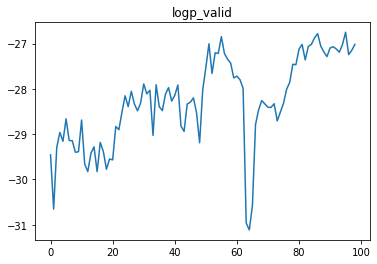

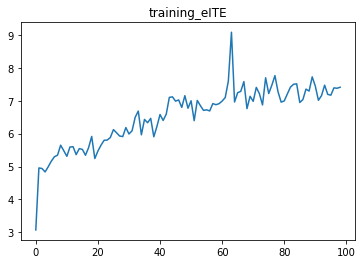

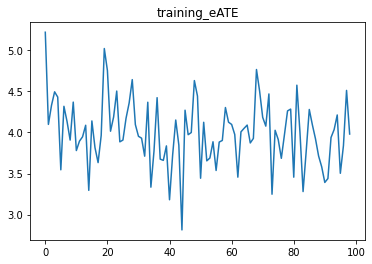

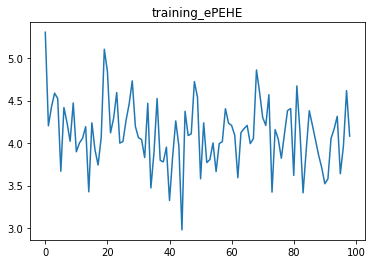

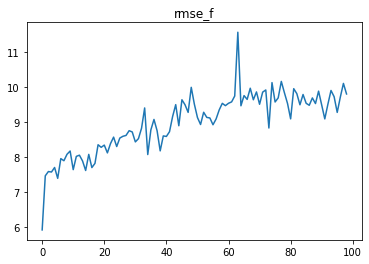

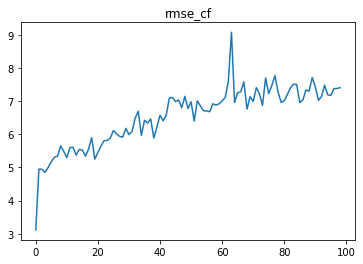

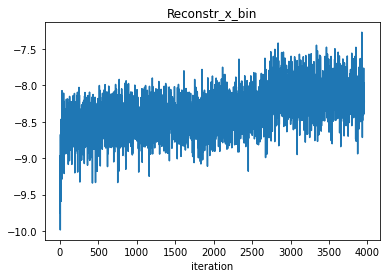

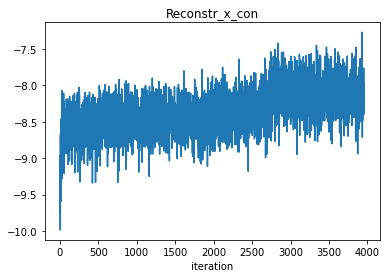

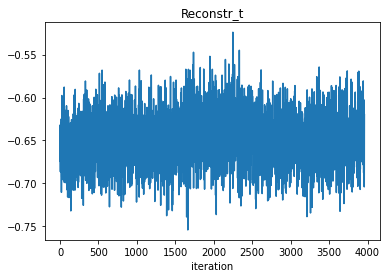

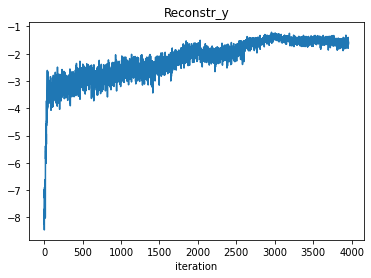

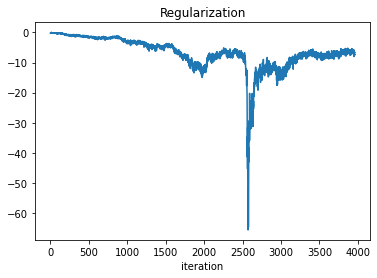

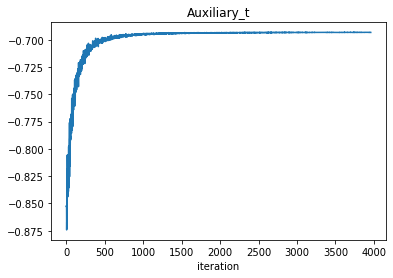

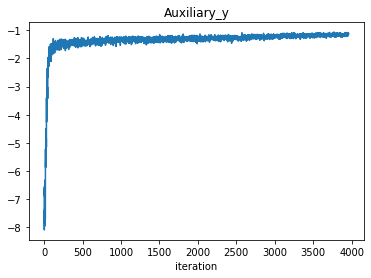

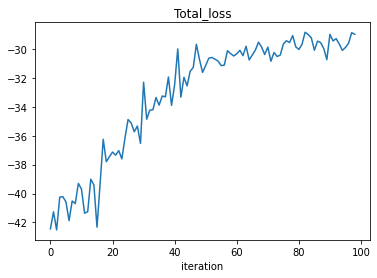

In [4]:
# normal
plt.title('logp_valid')
for i in range(args.reps):
    plt.plot(logpvalid_list[i][:epoch])
plt.show()

plt.title('training_eITE')
for i in range(args.reps):
    plt.plot(ite_train_list[i][:epoch])
plt.show()

plt.title('training_eATE')
for i in range(args.reps):
    plt.plot(ate_train_list[i][:epoch])
plt.show()

plt.title('training_ePEHE')
for i in range(args.reps):
    plt.plot(pehe_train_list[i][:epoch])
plt.show()

plt.title('rmse_f')
for i in range(args.reps):
    plt.plot(rmse_f_list[i][:epoch])
plt.show()

plt.title('rmse_cf')
for i in range(args.reps):
    plt.plot(rmse_cf_list[i][:epoch])
plt.show()

plt.title('Reconstr_x_bin')
plt.xlabel('iteration')
for i in range(args.reps):
    plt.plot(loss[1][i][:epoch*n_iter_per_epoch])
plt.show()

plt.title('Reconstr_x_con')
plt.xlabel('iteration')
for i in range(args.reps):
    plt.plot(loss[1][i][:epoch*n_iter_per_epoch])
plt.show()

plt.title('Reconstr_t')
plt.xlabel('iteration')
for i in range(args.reps):
    plt.plot(loss[2][i][:epoch*n_iter_per_epoch])
plt.show()

plt.title('Reconstr_y')
plt.xlabel('iteration')
for i in range(args.reps):
    plt.plot(loss[3][i][:epoch*n_iter_per_epoch])
plt.show()

plt.title('Regularization')
plt.xlabel('iteration')
for i in range(args.reps):
    plt.plot(loss[4][i][:epoch*n_iter_per_epoch])
plt.show()

plt.title('Auxiliary_t')
plt.xlabel('iteration')
for i in range(args.reps):
    plt.plot(loss[5][i][:epoch*n_iter_per_epoch])
plt.show()

plt.title('Auxiliary_y')
plt.xlabel('iteration')
for i in range(args.reps):
    plt.plot(loss[6][i][:epoch*n_iter_per_epoch])
plt.show()

plt.title('Total_loss')
plt.xlabel('iteration')
for i in range(args.reps):
    plt.plot(loss[7][i][:epoch])
plt.show()

In [5]:
# for proposal
wx = 1
wy = 2
wt = 0
wz = 0.5
wqy = 1
wqt = 0

# 評価指標保存用
scores = np.zeros((args.reps, 3))
scores_test = np.zeros((args.reps, 3))
ite_train_list = np.zeros([args.reps, args.epochs])
ate_train_list = np.zeros([args.reps, args.epochs])
pehe_train_list = np.zeros([args.reps, args.epochs])
rmse_f_list = np.zeros([args.reps, args.epochs])
rmse_cf_list = np.zeros([args.reps, args.epochs])
ite_test_list = np.zeros([args.reps, args.epochs])
ate_test_list = np.zeros([args.reps, args.epochs])
pehe_test_list = np.zeros([args.reps, args.epochs])
loss = np.zeros([8, args.reps, args.epochs*40])
logpvalid_list = np.zeros([args.reps, args.epochs])

# Loop for replications
for i, (train, valid, test, contfeats, binfeats) in enumerate(dataset.get_train_valid_test()):
    print('\nReplication %i/%i' % (i + 1, args.reps))
    
    torch.manual_seed(0)
    
    # read out data
    (xtr, ttr, ytr), (y_cftr, mu0tr, mu1tr) = train
    (xva, tva, yva), (y_cfva, mu0va, mu1va) = valid
    (xte, tte, yte), (y_cfte, mu0te, mu1te) = test

    #特徴量を離散値→連続値に並び替える
    perm = binfeats + contfeats
    xtr, xva, xte = xtr[:, perm], xva[:, perm], xte[:, perm]
    #トレーニング用データの連結
    xalltr, talltr, yalltr = np.concatenate([xtr, xva], axis=0), np.concatenate([ttr, tva], axis=0), np.concatenate([ytr, yva], axis=0)

    # set evaluator objects
    evaluator_train = Evaluator(yalltr, talltr, y_cf=np.concatenate([y_cftr, y_cfva], axis=0),
                                mu0=np.concatenate([mu0tr, mu0va], axis=0), mu1=np.concatenate([mu1tr, mu1va], axis=0))
    evaluator_test = Evaluator(yte, tte, y_cf=y_cfte, mu0=mu0te, mu1=mu1te)

    # zero mean, unit variance for y during training, use ym & ys to correct when using testset
    ym, ys = np.mean(ytr), np.std(ytr)
    ytr, yva = (ytr - ym) / ys, (yva - ym) / ys
    best_logpvalid = - np.inf
    
    # init networks (overwritten per replication)
    # xの次元設定
    x_dim = len(binfeats) + len(contfeats)
    p_x_z_dist = p_x_z(nh, d, h, binfeats, contfeats)
    p_t_z_dist = p_t_z(d, h)
    p_y_zt_dist = p_y_zt(d, nh, h)
    q_t_x_dist = q_t_x(h, x_dim)
    q_y_xt_dist = q_y_xt(nh, h, x_dim)
    q_z_tyx_dist = q_z_tyx(nh, h, d, x_dim)
    p_z_dist = normal.Normal(torch.zeros(args.z_dim), torch.ones(args.z_dim))
    # z = ed.Normal(loc=tf.zeros([tf.shape(input=x_ph)[0], args.z_dim]), scale=tf.ones([tf.shape(input=x_ph)[0], args.z_dim]))

    # Create optimizer
    params = list(p_x_z_dist.parameters()) + \
             list(p_t_z_dist.parameters()) + \
             list(p_y_zt_dist.parameters()) + \
             list(q_t_x_dist.parameters()) + \
             list(q_y_xt_dist.parameters()) + \
             list(q_z_tyx_dist.parameters())

    # Adam is used, like original implementation, in paper Adamax is suggested
    # optimizer = optim.Adamax(params, lr=args.lr, weight_decay=args.decay)
    optimizer = optim.Adam(params, lr=args.lr, weight_decay=args.decay)

    # init q_z inference ←これ何？
    q_z_tyx_dist = init_qz(q_z_tyx_dist, p_z_dist, ytr, ttr, xtr)

    # set batch size
    M = args.batch

    n_epoch, n_iter_per_epoch, idx = args.epochs, 10 * int(xtr.shape[0] / M), list(range(xtr.shape[0]))

    # loss = defaultdict(list)
    patience = 0
    for epoch in range(n_epoch):
        avg_loss = 0.
        # print('Epoch: %i/%i' % (epoch, n_epoch))
        # lossを0に初期化
        loss_sum = 0.
        t0 = time.time()
        widgets = ["epoch #%d|" % epoch, Percentage(), Bar(), ETA()]
        pbar = ProgressBar(n_iter_per_epoch, widgets=widgets)
        pbar.start()
        # shuffle index
        np.random.shuffle(idx)
        # take random batch for training
        for j in range(n_iter_per_epoch):
            pbar.update(j)
            # select random batch
            batch = np.random.choice(idx, M)
            x_train, y_train, t_train = torch.FloatTensor(xalltr[batch]), torch.FloatTensor(yalltr[batch]), \
                                        torch.FloatTensor(talltr[batch])
            x_val = torch.FloatTensor(xva)
            y_val = torch.FloatTensor(yva)
            t_val = torch.FloatTensor(tva)
            
            # inferred distribution over z
            xy = torch.cat((x_train, y_train), 1)
            z_infer = q_z_tyx_dist(x_train, t_train, y_train)
            z_infer_sample = z_infer.sample()
        
            # RECONSTRUCTION LOSS
            # p(x|z)
            x_bin, x_con = p_x_z_dist(z_infer_sample)
            l1 = x_bin.log_prob(x_train[:, :len(binfeats)]).sum(1)
            l2 = x_con.log_prob(x_train[:, -len(contfeats):]).sum(1)
            # p(t|z)
            t = p_t_z_dist(z_infer_sample)
            l3 = t.log_prob(t_train).squeeze()
            # p(y|t,z)
            # for training use t_train, in out-of-sample prediction this becomes t_infer
            y = p_y_zt_dist(z_infer_sample, t_train)
            l4 = y.log_prob(y_train).squeeze()
            
            # REGULARIZATION LOSS
            # p(z) - q(z|x,t,y)
            # approximate KL
            l5 = (p_z_dist.log_prob(z_infer_sample) - z_infer.log_prob(z_infer_sample)).sum(1)

            # AUXILIARY LOSS
            # q(t|x)
            t_infer = q_t_x_dist(x_train)
            l6 = t_infer.log_prob(t_train).squeeze()
            # q(y|x,t)
            y_infer = q_y_xt_dist(x_train, t_train)
            l7 = y_infer.log_prob(y_train).squeeze()

            # Total objective
            # inner sum to calculate loss per item, torch.mean over batch
            loss_mean = torch.mean(wx*l1 + wx*l2 + wt*l3 + wy*l4 + wz*l5 + wqt*l6 + wqy*l7)
            objective = -loss_mean

            optimizer.zero_grad()
            # Calculate gradients
            objective.backward()
            # Update step
            optimizer.step()
            #print('Epoch %i' % epoch)
            
            loss[0][i][epoch*n_iter_per_epoch+j] = l1.mean().cpu().detach().float() # Reconstr_x_bin
            loss[1][i][epoch*n_iter_per_epoch+j] = l2.mean().cpu().detach().float() # Reconstr_x_con
            loss[2][i][epoch*n_iter_per_epoch+j] = l3.mean().cpu().detach().float() # Reconstr_t
            loss[3][i][epoch*n_iter_per_epoch+j] = l4.mean().cpu().detach().float() # Reconstr_y
            loss[4][i][epoch*n_iter_per_epoch+j] = l5.mean().cpu().detach().float() # Regularization
            loss[5][i][epoch*n_iter_per_epoch+j] = l6.mean().cpu().detach().float() # Auxiliary_t
            loss[6][i][epoch*n_iter_per_epoch+j] = l7.mean().cpu().detach().float() # Auxiliary_y
            loss[7][i][epoch*n_iter_per_epoch+j] = loss_mean.cpu().detach().numpy() # Total
            avg_loss = avg_loss + loss_mean
        avg_loss = avg_loss / n_iter_per_epoch
        avg_loss = avg_loss / 100
        
        # y0, y1 = get_y0_y1(p_y_zt_dist, q_t_x_dist, q_y_xt_dist, q_z_tyx_dist, torch.tensor(xalltr), shape=yalltr.shape)
        # y0, y1 = get_y0_y1_2(p_y_zt_dist, q_t_x_dist, q_y_xt_dist, q_z_tyx_dist, torch.tensor(xalltr), torch.tensor(talltr), shape=yalltr.shape)
        y0, y1 = get_y0_y1_3(p_y_zt_dist, q_y_xt_dist, q_z_tyx_dist, torch.tensor(xalltr), torch.tensor(talltr), shape=yalltr.shape)
        y0, y1 = y0 * ys + ym, y1 * ys + ym
        score_train = evaluator_train.calc_stats(y1, y0)
        rmses_train = evaluator_train.y_errors(y0, y1)
        ite_train_list[i][epoch] = score_train[0]
        ate_train_list[i][epoch] = score_train[1]
        pehe_train_list[i][epoch] = score_train[2]
        rmse_f_list[i][epoch] = rmses_train[0]
        rmse_cf_list[i][epoch] = rmses_train[1]
        
        xy_eval = torch.cat((x_val, y_val), 1)
        z_eval = q_z_tyx_dist(x_val, t_val, y_val)
        z_eval_sample = z_eval.sample()
        x_bin_eval, x_con_eval = p_x_z_dist(z_eval.mean)
        t_eval = p_t_z_dist(z_eval.mean)
        y_post_eval = p_y_zt_dist(z_eval.mean, t_val)
        lv1 = y_post_eval.log_prob(y_val).squeeze()
        lv2 = t_eval.log_prob(t_val).squeeze()
        lv3 = x_bin_eval.log_prob(x_val[:, :len(binfeats)]).sum(1)
        lv4 = x_con_eval.log_prob(x_val[:, -len(contfeats):]).sum(1)
        lv5 = (p_z_dist.log_prob(z_eval_sample) - z_eval.log_prob(z_eval_sample)).sum(1)
        logpvalid =  torch.mean(wy*lv1 + wt*lv2 + wx*lv3 + wx*lv4 + wz*lv5).item()
        logpvalid_list[i][epoch] = logpvalid
        
        # early stoping
        if epoch % args.earl == 0 or epoch == (n_epoch - 1):
            if logpvalid >= best_logpvalid:
                print('Improved validation bound, old: {:0.3f}, new: {:0.3f}'.format(best_logpvalid, logpvalid))
                best_logpvalid = logpvalid
                model = models.mnasnet0_5()
                torch.save(model.to('cpu').state_dict(), 'models/m6-ihdp')
        
        """
        if epoch == 0 :
            patience = 0
        else:
            if logpvalid_list[i][epoch] >= logpvalid_list[i][epoch-1]:
                # ('Improved validation bound, old: {:0.3f}, new: {:0.3f}'.format(best_logpvalid, logpvalid))
                # best_logpvalid = logpvalid
                patience = 0
            else:
                patience = patience + 1
        
        if epoch > 40 and patience > 3:
            break
        """
        
        if epoch % args.print_every == 0:
            # y0, y1 = get_y0_y1(p_y_zt_dist, q_t_x_dist, q_y_xt_dist, q_z_tyx_dist, torch.tensor(xte), shape=yte.shape)
            # y0, y1 = get_y0_y1_2(p_y_zt_dist, q_t_x_dist, q_y_xt_dist, q_z_tyx_dist, torch.tensor(xte), torch.tensor(tte), shape=yte.shape)
            y0, y1 = get_y0_y1_3(p_y_zt_dist, q_y_xt_dist, q_z_tyx_dist, torch.tensor(xte), torch.tensor(tte), shape=yte.shape)
            y0, y1 = y0 * ys + ym, y1 * ys + ym
            score_test = evaluator_test.calc_stats(y1, y0)
            print('Epoch %i' % epoch)
            print(avg_loss.item())
            print('Training set - ite: %f, ate: %f, pehe: %f' %score_train)
            print('Training set - rmse factual: %f, rmse counterfactual: %f' %rmses_train)
            print('Testset - ite: %f, ate: %f, pehe: %f' % score_test)
    
    model = models.mnasnet0_5()
    model.load_state_dict(torch.load('models/m6-ihdp'))
    # y0, y1 = get_y0_y1(p_y_zt_dist, q_t_x_dist, q_y_xt_dist, q_z_tyx_dist, torch.tensor(xalltr), shape=yalltr.shape)
    # y0, y1 = get_y0_y1_2(p_y_zt_dist, q_t_x_dist, q_y_xt_dist, q_z_tyx_dist, torch.tensor(xalltr), torch.tensor(talltr), shape=yalltr.shape)
    y0, y1 = get_y0_y1_3(p_y_zt_dist, q_y_xt_dist, q_z_tyx_dist, torch.tensor(xalltr), torch.tensor(talltr), shape=yalltr.shape)
    y0, y1 = y0 * ys + ym, y1 * ys + ym
    score = evaluator_train.calc_stats(y1, y0)
    scores[i, :] = score

    # y0t, y1t = get_y0_y1(p_y_zt_dist, q_t_x_dist, q_y_xt_dist, q_z_tyx_dist, torch.tensor(xte), shape=yte.shape)
    # y0t, y1t = get_y0_y1_2(p_y_zt_dist, q_t_x_dist, q_y_xt_dist, q_z_tyx_dist, torch.tensor(xte), torch.tensor(tte), shape=yte.shape)
    y0t, y1t = get_y0_y1_3(p_y_zt_dist, q_y_xt_dist, q_z_tyx_dist, torch.tensor(xte), torch.tensor(tte), shape=yte.shape)
    y0t, y1t = y0t * ys + ym, y1t * ys + ym
    score_test = evaluator_test.calc_stats(y1t, y0t)
    scores_test[i, :] = score_test

    print('Replication: {}/{}, tr_ite: {:0.3f}, tr_ate: {:0.3f}, tr_pehe: {:0.3f}' \
              ', te_ite: {:0.3f}, te_ate: {:0.3f}, te_pehe: {:0.3f}'.format(i + 1, args.reps, score[0], score[1], score[2], score_test[0], score_test[1], score_test[2]))

print('CEVAE model total scores')
means, stds = np.mean(scores, axis=0), sem(scores, axis=0)
print('train ITE: {:.3f}+-{:.3f}, train ATE: {:.3f}+-{:.3f}, train PEHE: {:.3f}+-{:.3f}' \
      ''.format(means[0], stds[0], means[1], stds[1], means[2], stds[2]))

means, stds = np.mean(scores_test, axis=0), sem(scores_test, axis=0)
print('test ITE: {:.3f}+-{:.3f}, test ATE: {:.3f}+-{:.3f}, test PEHE: {:.3f}+-{:.3f}' \
      ''.format(means[0], stds[0], means[1], stds[1], means[2], stds[2]))       


Replication 1/1


Improved validation bound, old: -inf, new: -32.712


Epoch 0
-0.4206695854663849
Training set - ite: 3.005116, ate: 5.011882, pehe: 5.093645
Training set - rmse factual: 5.722011, rmse counterfactual: 3.027156
Testset - ite: 3.212246, ate: 5.157455, pehe: 5.222167


Epoch 10
-0.283661812543869
Training set - ite: 10.501685, ate: 5.298614, pehe: 5.358456
Training set - rmse factual: 7.326875, rmse counterfactual: 10.471829
Testset - ite: 10.416541, ate: 5.193573, pehe: 5.243286


Improved validation bound, old: -32.712, new: -32.395


Improved validation bound, old: -32.395, new: -31.813


Improved validation bound, old: -31.813, new: -31.348


Improved validation bound, old: -31.348, new: -30.684


Improved validation bound, old: -30.684, new: -30.549


Improved validation bound, old: -30.549, new: -29.520


Epoch 20
-0.2996739447116852
Training set - ite: 10.400409, ate: 4.991831, pehe: 5.029201
Training set - rmse factual: 7.372485, rmse counterfactual: 10.375623
Testset - ite: 10.291516, ate: 4.991742, pehe: 5.025186


Improved validation bound, old: -29.520, new: -29.442


Improved validation bound, old: -29.442, new: -29.297


Improved validation bound, old: -29.297, new: -28.853


Epoch 30
-0.2944985628128052
Training set - ite: 10.141973, ate: 5.187230, pehe: 5.222425
Training set - rmse factual: 6.979651, rmse counterfactual: 10.112108
Testset - ite: 10.050942, ate: 5.165153, pehe: 5.201475


Epoch 40
-0.28794339299201965
Training set - ite: 10.056353, ate: 4.902054, pehe: 4.953976
Training set - rmse factual: 7.090313, rmse counterfactual: 10.020807
Testset - ite: 9.968410, ate: 4.808404, pehe: 4.852736


Epoch 50
-0.3237999379634857
Training set - ite: 9.933124, ate: 4.937413, pehe: 4.978379
Training set - rmse factual: 6.924345, rmse counterfactual: 9.903078
Testset - ite: 9.833597, ate: 4.970858, pehe: 5.012869


Epoch 60
-0.3500322699546814
Training set - ite: 10.016056, ate: 3.919069, pehe: 3.976649
Training set - rmse factual: 7.619493, rmse counterfactual: 10.000258
Testset - ite: 9.962850, ate: 3.962714, pehe: 4.025303


Improved validation bound, old: -28.853, new: -28.007


Epoch 70
-0.5529367327690125
Training set - ite: 10.099719, ate: 4.800047, pehe: 4.963317
Training set - rmse factual: 7.240210, rmse counterfactual: 10.093757
Testset - ite: 10.045937, ate: 4.889221, pehe: 5.017590


Epoch 80
-0.4820990264415741
Training set - ite: 9.901589, ate: 4.525173, pehe: 4.844222
Training set - rmse factual: 7.237775, rmse counterfactual: 9.875099
Testset - ite: 9.852010, ate: 4.692030, pehe: 4.985501


Epoch 90
-0.5530782341957092
Training set - ite: 9.792835, ate: 4.536750, pehe: 5.020902
Training set - rmse factual: 7.170773, rmse counterfactual: 9.761403
Testset - ite: 9.745976, ate: 4.761716, pehe: 5.176587


Replication: 1/1, tr_ite: 10.294, tr_ate: 4.994, tr_pehe: 5.466, te_ite: 10.304, te_ate: 5.139, te_pehe: 5.512
CEVAE model total scores
train ITE: 10.294+-nan, train ATE: 4.994+-nan, train PEHE: 5.466+-nan
test ITE: 10.304+-nan, test ATE: 5.139+-nan, test PEHE: 5.512+-nan


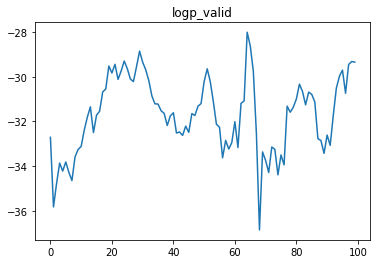

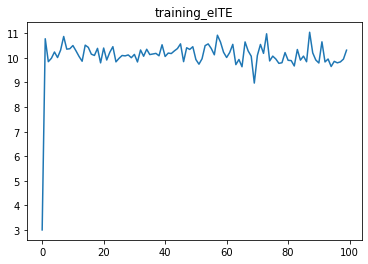

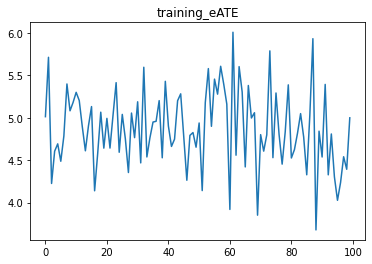

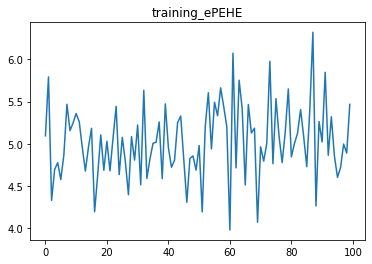

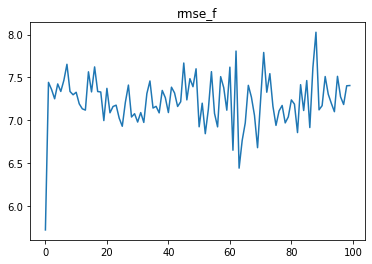

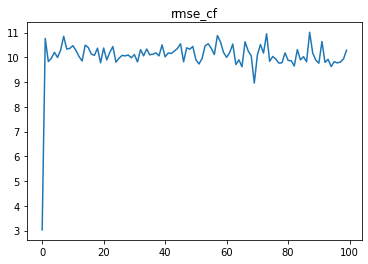

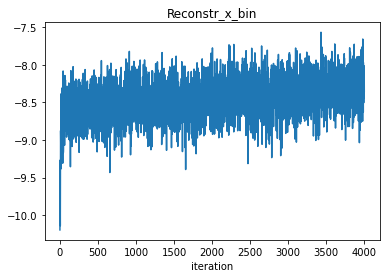

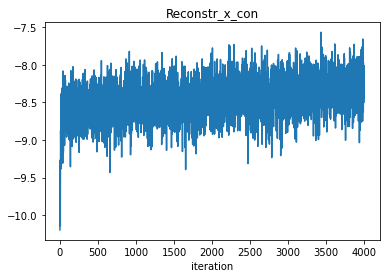

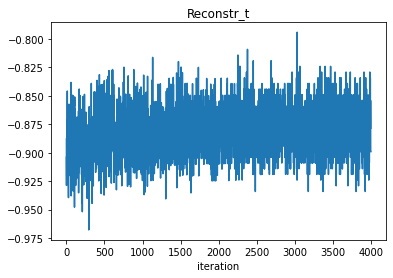

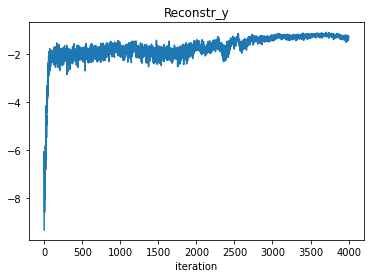

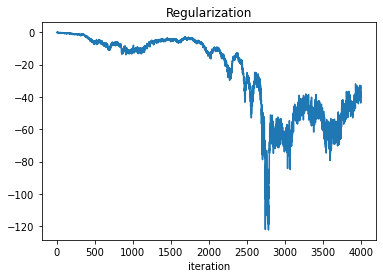

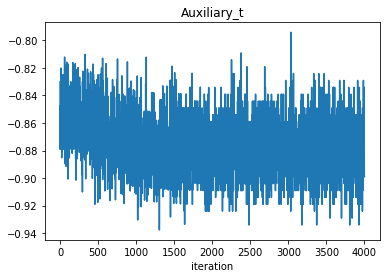

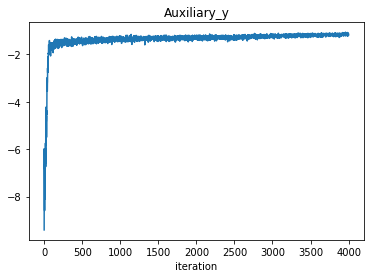

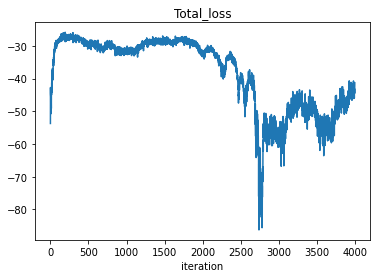

In [6]:
plt.title('logp_valid')
for i in range(args.reps):
    plt.plot(logpvalid_list[i])
plt.show()

plt.title('training_eITE')
for i in range(args.reps):
    plt.plot(ite_train_list[i])
plt.show()

plt.title('training_eATE')
for i in range(args.reps):
    plt.plot(ate_train_list[i])
plt.show()

plt.title('training_ePEHE')
for i in range(args.reps):
    plt.plot(pehe_train_list[i])
plt.show()

plt.title('rmse_f')
for i in range(args.reps):
    plt.plot(rmse_f_list[i])
plt.show()

plt.title('rmse_cf')
for i in range(args.reps):
    plt.plot(rmse_cf_list[i])
plt.show()

plt.title('Reconstr_x_bin')
plt.xlabel('iteration')
for i in range(args.reps):
    plt.plot(loss[1][i])
plt.show()

plt.title('Reconstr_x_con')
plt.xlabel('iteration')
for i in range(args.reps):
    plt.plot(loss[1][i])
plt.show()

plt.title('Reconstr_t')
plt.xlabel('iteration')
for i in range(args.reps):
    plt.plot(loss[2][i])
plt.show()

plt.title('Reconstr_y')
plt.xlabel('iteration')
for i in range(args.reps):
    plt.plot(loss[3][i])
plt.show()

plt.title('Regularization')
plt.xlabel('iteration')
for i in range(args.reps):
    plt.plot(loss[4][i])
plt.show()

plt.title('Auxiliary_t')
plt.xlabel('iteration')
for i in range(args.reps):
    plt.plot(loss[5][i])
plt.show()

plt.title('Auxiliary_y')
plt.xlabel('iteration')
for i in range(args.reps):
    plt.plot(loss[6][i])
plt.show()

plt.title('Total_loss')
plt.xlabel('iteration')
for i in range(args.reps):
    plt.plot(loss[7][i])
plt.show()

In [ ]:
# proposal
plt.title('logp_valid')
for i in range(args.reps):
    plt.plot(logpvalid_list[i][:epoch])
plt.show()

plt.title('training_eITE')
for i in range(args.reps):
    plt.plot(ite_train_list[i][:epoch])
plt.show()

plt.title('training_eATE')
for i in range(args.reps):
    plt.plot(ate_train_list[i][:epoch])
plt.show()

plt.title('training_ePEHE')
for i in range(args.reps):
    plt.plot(pehe_train_list[i][:epoch])
plt.show()

plt.title('rmse_f')
for i in range(args.reps):
    plt.plot(rmse_f_list[i][:epoch])
plt.show()

plt.title('rmse_cf')
for i in range(args.reps):
    plt.plot(rmse_cf_list[i][:epoch])
plt.show()

plt.title('Reconstr_x_bin')
plt.xlabel('iteration')
for i in range(args.reps):
    plt.plot(loss[1][i][:epoch*n_iter_per_epoch])
plt.show()

plt.title('Reconstr_x_con')
plt.xlabel('iteration')
for i in range(args.reps):
    plt.plot(loss[1][i][:epoch*n_iter_per_epoch])
plt.show()

plt.title('Reconstr_t')
plt.xlabel('iteration')
for i in range(args.reps):
    plt.plot(loss[2][i][:epoch*n_iter_per_epoch])
plt.show()

plt.title('Reconstr_y')
plt.xlabel('iteration')
for i in range(args.reps):
    plt.plot(loss[3][i][:epoch*n_iter_per_epoch])
plt.show()

plt.title('Regularization')
plt.xlabel('iteration')
for i in range(args.reps):
    plt.plot(loss[4][i][:epoch*n_iter_per_epoch])
plt.show()

plt.title('Auxiliary_t')
plt.xlabel('iteration')
for i in range(args.reps):
    plt.plot(loss[5][i][:epoch*n_iter_per_epoch])
plt.show()

plt.title('Auxiliary_y')
plt.xlabel('iteration')
for i in range(args.reps):
    plt.plot(loss[6][i][:epoch*n_iter_per_epoch])
plt.show()

plt.title('Total_loss')
plt.xlabel('iteration')
for i in range(args.reps):
    plt.plot(loss[7][i][:epoch])
plt.show()

plt.figure()
plt.plot(np.array(loss['Total']), label='Total')
plt.title('Variational Lower Bound')
plt.show()

for key, value in loss.items():
    plt.figure()
    plt.plot(np.array(value), label=key)
    plt.title(key)
    plt.show()